# Markov Chain Monte Carlo using preconditioned Crank Nicolson proposals.

### This notebook demonstrates the use of standard Metropolis-Hastings MCMC, using pCN proposals to find the minima of the Rosenbrock and Ackley functions, respectively.

In [80]:
# Import the good stuff.
import numpy as np
from numpy import dot
from numpy.linalg import inv, det
import matplotlib.pyplot as plt

## Base classes: Link and Chain

In [81]:
# Link is an abstract class that can be extended with actual evaluation, prior and likelihood methods.
# It holds member parameters and functions that are unique to each link.
class Link:
    def __init__(self, params, prior_location, prior_scale, likelihood_scale):
        self.params = np.array(params)
        self.prior_location = prior_location
        self.prior_scale = prior_scale
        self.likelihood_scale = likelihood_scale
        self.output = self.evaluate()
        self.posterior = self.compute_posterior()
    
    # The following methods are just placeholders, so that more useful 
    # methods can be created with inheritance. The class is set up
    # To handle log-likelihoods rather than likelihoods.
    def evaluate(self):
        return 0
    
    def prior(self):
        return 0
    
    def likelihood(self):
        return 0

    def compute_posterior(self):
        return self.prior() + self.likelihood()

In [59]:
# Chain implements the preconditioned Crank-Nicolson proposal distribution and standard Metropolis-Hastings MCMC.
class Chain:
    def __init__(self, bounds, prior_location, prior_scale, likelihood_scale, proposal_scale, beta_pCN):
        
        self.beta = beta_pCN
        self.prior_location = np.array(prior_location)
        self.prior_scale = np.array(prior_scale)
        self.likelihood_scale = likelihood_scale
        self.proposal_scale = proposal_scale
        
        # Create an initial random link from the bounds supplied to the constructor.
        initial_parameters = []
        for b in bounds:
            initial_parameters += [np.random.uniform(b[0], b[1])]
        
        # Create a chain and put the first link in it.
        self.chain = [Link(initial_parameters, 
                           self.prior_location, 
                           self.prior_scale, 
                           self.likelihood_scale)]
        
        # Create an empty list for acceptance budgeting.
        self.acceptance = []
        
    # preconditioned Crank Nicolson (pCN) proposal is created, based on the previous link.
    def proposal(self, previous_link):
        return np.sqrt(1 - self.beta**2)*previous_link.params + self.beta*np.random.normal(0, self.proposal_scale)
    
    # This method implements the standard Metrpolis Hastings MCMC algorithm 
    # and extends the chain according to the number of iterations
    def run(self, iterations):
        for i in range(iterations):
            new_proposal = Link(self.proposal(self.chain[-1]), 
                                self.prior_location, 
                                self.prior_scale, 
                                self.likelihood_scale)
            
            alpha = np.exp(new_proposal.posterior - self.chain[-1].posterior)
            
            if np.random.random() < alpha:
                self.chain += [new_proposal]
                self.acceptance += [1]
            else:
                self.chain += [self.chain[i]]
                self.acceptance += [0]

## The Rosenbrock function

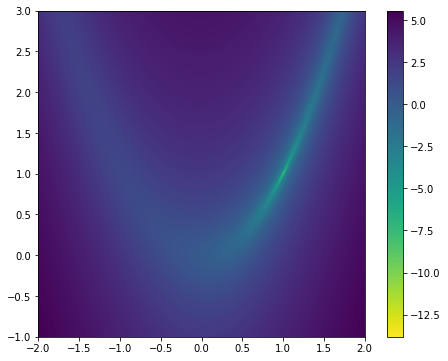

In [60]:
# An example of the Rosenbrock function, which is the first function
# that we will try and estimate with the MCMC.
def rosenbrock(x,y):
    return (1-x)**2 + 10*(y-x**2)**2

xx = np.linspace(-2,2, 1000); yy = np.linspace(-1,3, 1000); X, Y = np.meshgrid(xx,yy)
surf = rosenbrock(X,Y)
plt.figure(figsize = (8,6))
# The log of the function values are plotted since it scales better with the colormap.
plt.imshow(np.log(surf), origin = 'lower', cmap = 'viridis_r', extent = [-2, 2, -1, 3]); plt.colorbar()
plt.show()

In [82]:
# The link class is extended for use with the Rosenbrock function.
class Link(Link):
    # This is the formula for the Rosenbrock function
    def evaluate(self):
        return (1-self.params[0])**2 + 10*(self.params[1] - self.params[0]**2)**2
    
    # Priors are computed using a multivariate normal distribution.
    def prior(self):
        dist = self.params - self.prior_location
        SIGMA = np.diag(self.prior_scale)
        return np.log(np.exp(-1/2 * dot(dot(dist, inv(SIGMA)), dist))/np.sqrt((2*np.pi)**len(dist)*det(SIGMA)))
    
    # Likelihood is computed using squared L2 norm likelihood function.
    def likelihood(self):
        return -np.linalg.norm(self.output)**2/(2*self.likelihood_scale)

In [83]:
# All the relevant parameters are set.
bounds = [(-2, 2), (-2, 2)]
prior_location = [1, 1]
prior_scale = [1, 1]
likelihood_scale = 1
proposal_scale = [2, 4]
beta_pCN = 0.15

# A chain is instantiated and run for a number of iterations
chain = Chain(bounds, prior_location, prior_scale, likelihood_scale, proposal_scale, beta_pCN)
chain.run(20000)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


Acceptance ratio: 0.2966666666666667


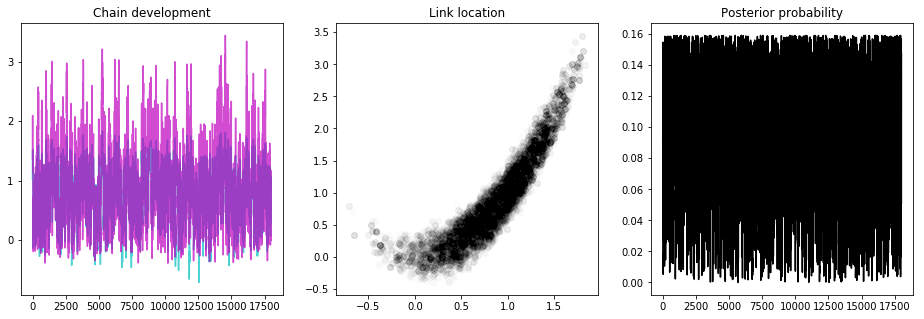

In [84]:
# Set the burnin.
burnin = 2000

# Print the acceptance ratio
print('Acceptance ratio: {}'.format(np.mean(chain.acceptance[burnin:])))

# Do some nice plotting of the chain.
x = [i.params[0] for i in chain.chain][burnin:]
y = [i.params[1] for i in chain.chain][burnin:]
post_prob = [np.exp(i.posterior) for i in chain.chain][burnin:]

fig, axs = plt.subplots(1, 3, figsize=(16,5))

xplot = axs[0].plot(x, color = 'c', alpha = 0.7); 
yplot = axs[0].plot(y, color = 'm', alpha = 0.7); axs[0].set_title('Chain development')
location = axs[1].scatter(x, y, color = 'k', alpha = 0.01); axs[1].set_title('Link location')
posterior = axs[2].plot(post_prob, color = 'k'); axs[2].set_title('Posterior probability')
plt.show()

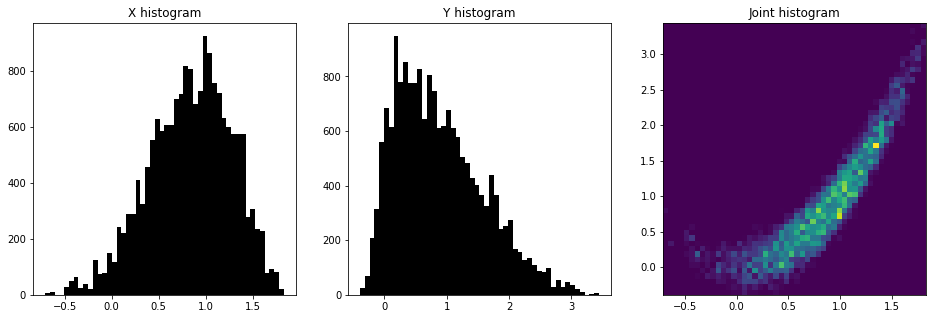

In [85]:
# More plotting. Histograms!
fig, axs = plt.subplots(1, 3, figsize=(16,5))
xhist = axs[0].hist(x, bins = 50, color = 'k'); axs[0].set_title('X histogram')
yhist = axs[1].hist(y, bins = 50, color = 'k'); axs[1].set_title('Y histogram')
jhist = axs[2].hist2d(x, y, bins = (50, 50)); axs[2].set_title('Joint histogram');
plt.show()

## The Ackley function.

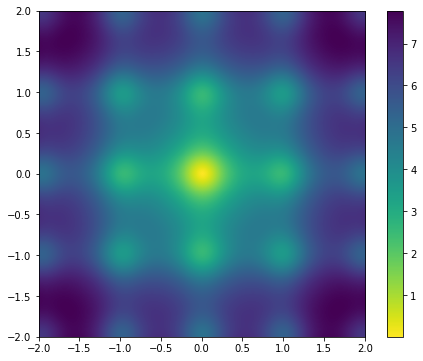

In [87]:
# An example of the Ackley function, which is the second function
# that we will try and estimate with the MCMC.

def ackley(x,y):
    return -20*np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))-np.exp(0.5*(np.cos(2*np.pi*x)+np.cos(2*np.pi*y))) + 22.7182818284590446

xx = np.linspace(-2,2, 1000); yy = np.linspace(-2,2, 1000); X, Y = np.meshgrid(xx,yy)
surf = ackley(X,Y)
plt.figure(figsize = (8,6))
plt.imshow(surf, origin = 'lower', cmap = 'viridis_r', extent = [-2, 2, -2, 2]); plt.colorbar()
plt.show()

In [88]:
# The link class is extended, this time evaluated for the Ackley function.
class Link(Link):
    def evaluate(self):
        return -20*np.exp(-0.2*np.sqrt(0.5*(self.params[0]**2+self.params[1]**2)))-np.exp(0.5*(np.cos(2*np.pi*self.params[0])+np.cos(2*np.pi*self.params[1]))) + 20 + np.exp(1)
    
    # Priors are computed using multivariate normal distribution.
    def prior(self):
        dist = self.params - self.prior_location
        SIGMA = np.diag(self.prior_scale)
        return np.log(np.exp(-1/2 * dot(dot(dist, inv(SIGMA)), dist))/np.sqrt((2*np.pi)**len(dist)*det(SIGMA)))
    
    # The likelihood is computed using squared L2 norm.
    def likelihood(self):
        return -np.linalg.norm(self.output)**2/(2*self.likelihood_scale)

In [89]:
# All the parameters are set.
bounds = [(-2, 2), (-2, 2)]
prior_location = [0, 0]
prior_scale = [1, 1]
likelihood_scale = 1
proposal_scale = [1, 1]
beta_pCN = 0.25

# A chain is initialised and run for some iterations
chain = Chain(bounds, prior_location, prior_scale, likelihood_scale, proposal_scale, beta_pCN)
chain.run(20000)

Acceptance ratio: 0.32422222222222224


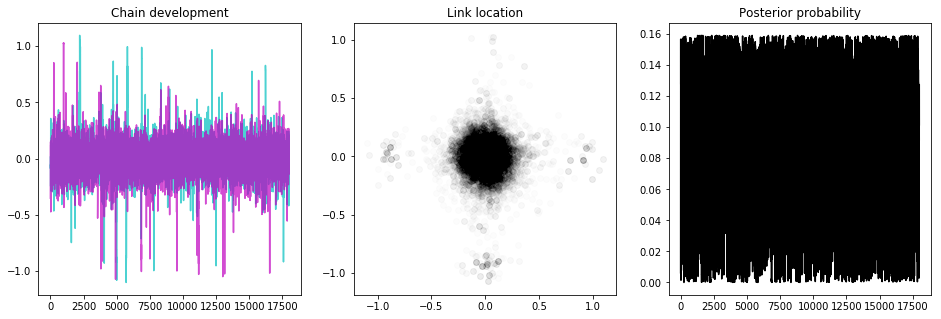

In [90]:
# Set the burnin.
burnin = 2000

# Print the acceptance ratio.
print('Acceptance ratio: {}'.format(np.mean(chain.acceptance[burnin:])))

# Do some more plotting
x = [i.params[0] for i in chain.chain][burnin:]
y = [i.params[1] for i in chain.chain][burnin:]
post_prob = [np.exp(i.posterior) for i in chain.chain][burnin:]

fig, axs = plt.subplots(1, 3, figsize=(16,5))

xplot = axs[0].plot(x, color = 'c', alpha = 0.7); 
yplot = axs[0].plot(y, color = 'm', alpha = 0.7); axs[0].set_title('Chain development')
location = axs[1].scatter(x, y, color = 'k', alpha = 0.01); axs[1].set_title('Link location')
posterior = axs[2].plot(post_prob, color = 'k'); axs[2].set_title('Posterior probability')
plt.show()

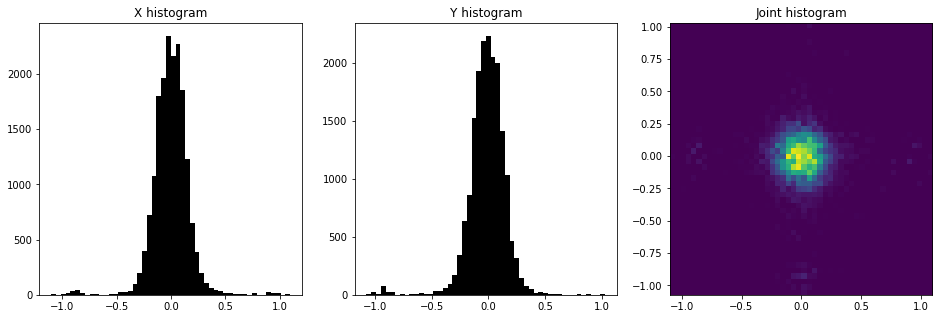

In [91]:
# More plotting. Histograms!
fig, axs = plt.subplots(1, 3, figsize=(16,5))
xhist = axs[0].hist(x, bins = 50, color = 'k'); axs[0].set_title('X histogram')
yhist = axs[1].hist(y, bins = 50, color = 'k'); axs[1].set_title('Y histogram')
jhist = axs[2].hist2d(x, y, bins = (50, 50)); axs[2].set_title('Joint histogram');
plt.show()